In [1]:
from system import TradingEnv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np

import random
import math

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
e = TradingEnv()

In [4]:
STATE_DIM = len(e.reset())
ACTION_DIM = 3
EPISODES = 2000  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
GAMMA = 0.99  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
HIDDEN_LAYER = 10  # NN hidden layer size
BATCH_SIZE = 500  # Q-learning batch size
TARGET_UPDATE = 100  # frequency of target update
BUFFER_SIZE = 10000  # capacity of the replay buffer 

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [5]:
del e

In [6]:
if use_cuda:
    print('GPU found and in use')
else:
    print('No GPU will be used')

No GPU will be used


# Simple QNetwork 
Corresponds to a fully connected network with two hidden layers

In [7]:
class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x      
    
    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1,1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()

# Generic Training Agent

In [8]:
class BaseAgent:
    def __init__(self, gamma=0.8):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}" 
        self.gamma = gamma
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.rewards_history = []
        
    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
        """
        raise NotImplementedError()
    
    def plot_cumulative_discounted_rewards(self):
        """
            rewards_list: a list of lists, with shape n_episodes x n_steps
        """
        rewards = np.array(self.rewards_history)
        discount_array = np.power(0.8, np.arange(rewards.shape[0]))
        plt.plot((discount_array[:, None] * rewards).sum(axis=1))
        plt.grid()
        plt.ylabel('Cumulative Discounted Rewards')
        plt.xlabel('Episode')

    def convert_action(self, action):
        """
            Takes action of shape 1 x 3, and converts into an integer in {-1, 0, 1}.
            This integer is the position short/hold/long respectively.
        """
        position = torch.argmax(action, dim=-1) - 1
        assert position in [-1,0,1]
        return position
        
class DQN(BaseAgent):
    def __init__(self):
        super().__init__()
        self.model = QNetwork()
        self.target = QNetwork()
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.target(state).data.max(1)[1].view(1, 1)
        else:
            return LongTensor([[random.randrange(3)]])
    
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
#             if steps % 50 == 0:
#                 print(f'steps = {steps}')
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
#             print(f'action = {action}')            
#             print(f'position = {position}')
#             print(f'next_state length = {len(next_state)}')
#             print(f'reward = {reward}')
            self.memory.push((FloatTensor([state]),
                         action,  # action is already a tensor
                         FloatTensor([next_state]),
                         FloatTensor([reward]),
                         FloatTensor([int(done)])))

            self.learn()
            state = next_state
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)
        
    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]
    
    def learn(self):
        if len(self.memory) <= BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)
        
        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (1-batch_done)

        # loss is measured from error between current and newly expected Q values
        loss = F.mse_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
# agent=DQN()
# env = TradingEnv()
# for i in range(10):
#     s = FloatTensor([env.reset()])
#     agent.steps_done=100
#     print(agent.select_epsilon_greedy_action(s))

# agent.run_episode(env)

In [9]:
from tqdm import tqdm
agent=DQN()
# env = TradingEnv()
# # plt.plot(env.rewards_list)
# for i in tqdm(range(10)):
#     env = TradingEnv()
#     agent.run_episode(env)
# agent.plot_cumulative_discounted_rewards()

In [10]:
%load_ext line_profiler

In [11]:
e = TradingEnv()

In [ ]:
%lprun -f agent.run_episode [agent.run_episode(e) for _ in range(50)]

In [13]:
_ = e.reset()
%lprun -f e.step e.step(1)

Timer unit: 1e-06 s

Total time: 0.001903 s
File: /home/aaruran/Documents/Git/rl-course/project/system.py
Function: step at line 123

Line #      Hits         Time  Per Hit   % Time  Line Contents
   123                                               def step(self, action):
   124                                                   """
   125                                                       Executes an action in the stock environment, using 
   126                                                       the discrete action space described in: Deep Reinforcement Learning for Trading
   127                                                       
   128                                                       i.e. -1 is maximally short, 0 is no holdings, 1 is maximally long
   129                                                       Inputs: action (one of {-1,0,1})
   130                                                       Outputs: a tuple (observation/state, step_reward, is_done, info)
  

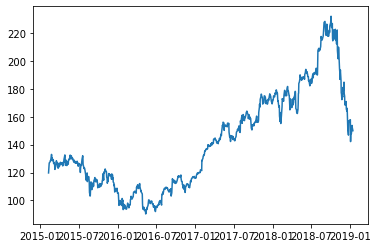

In [14]:
plt.plot(e.prices)

In [15]:
env.actions_list

NameError: name 'env' is not defined

In [ ]:
len(agent.rewards_history), len(agent.rewards_history[0])

In [ ]:
rewards = np.array(agent.rewards_history)
discount_array = np.power(0.8, np.arange(rewards.shape[0]))
plt.plot((discount_array[:, None] * rewards).sum(axis=1))
# discount_array.shape
# rewards.mean(axis=1)

In [ ]:
agent.plot_cumulative_discounted_rewards(np.array(agent.rewards_history))

In [ ]:
env.df_index

In [ ]:
import pandas as pd
pd.isna(env.data.iloc[365])

In [ ]:
%debug

In [ ]:
agent.convert_action(FloatTensor([[0]]))
# %debug

# Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, 2) # 2, for the action

    def forward(self, x, d=1, get_log=False):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if not get_log:
            x = F.softmax(self.l3(x), dim=d)
        else:
            x = F.log_softmax(self.l3(x), dim=d)
        return x
    
    def sample_from_softmax_policy(self, batch_state):
        batch_pi = self.forward(batch_state)
        batch_size = batch_pi.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            actions[i, 0] = dist.sample().view(1,1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# p = PolicyNetwork()
# state = env.reset()
# state_tensor = FloatTensor([state]).cuda()
# p.cuda()
# p.forward(state_tensor, d=1), p.forward(state_tensor, d=-1)
# p.sample_from_softmax_policy(torch.cat(5*[state_tensor])).shape